In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
from joblib import dump, load
import shap


In [20]:
## Functions
def evaluate_linear_baseline(data, base_features, max_degree=2, combo_size=5):
    results = []

    # Crear bloques temporales
    all_weeks = sorted(data['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+26] for i in range(0, len(all_weeks), 26)]

    # Probar combinaciones de variables
    for feature_combo in combinations(base_features, combo_size):
        feature_combo = list(feature_combo)

        for degree in range(1, max_degree+1):
            rmses_train, rmses_test, corrs_train, corrs_test = [], [], [], []

            for week_block in week_blocks:
                fold_test = data[data['week'].isin(week_block)].copy()
                fold_train = data[~data['week'].isin(week_block)].copy()

                if fold_test.empty or fold_train.empty:
                    continue

                try:
                    # Subset y eliminar NaNs
                    train_subset = fold_train[feature_combo + ['Precipitacion']].dropna()
                    test_subset = fold_test[feature_combo + ['Precipitacion']].dropna()

                    if train_subset.empty or test_subset.empty:
                        continue

                    # Separar X e y
                    X_train_raw = train_subset[feature_combo]
                    y_train = train_subset['Precipitacion']

                    X_test_raw = test_subset[feature_combo]
                    y_test = test_subset['Precipitacion']

                    # Transformaciones polinómicas
                    poly = PolynomialFeatures(degree=degree, include_bias=False)
                    X_train = poly.fit_transform(X_train_raw)
                    X_test = poly.transform(X_test_raw)
                    
                    

                    # Entrenar modelo
                    model_linear = LinearRegression()
                    
                    model_linear.fit(X_train, y_train)

                    # Predicciones
                    preds_train = model_linear.predict(X_train)
                    preds_test = model_linear.predict(X_test)

                    # RMSE
                    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
                    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

                    # Correlaciones protegidas
                    valid_train = ~np.isnan(y_train) & ~np.isnan(preds_train)
                    valid_test = ~np.isnan(y_test) & ~np.isnan(preds_test)

                    corr_train = pearsonr(y_train[valid_train], preds_train[valid_train])[0] if valid_train.sum() > 1 else np.nan
                    corr_test = pearsonr(y_test[valid_test], preds_test[valid_test])[0] if valid_test.sum() > 1 else np.nan

                    # Guardar métricas
                    rmses_train.append(rmse_train)
                    rmses_test.append(rmse_test)
                    corrs_train.append(corr_train)
                    corrs_test.append(corr_test)

                except Exception as e:
                    # Salta bloque si algo falla (opcional)
                    print(f"[WARN] Falló combo {feature_combo} con grado {degree}: {e}")
                    continue

            # Guardar resumen del fold
            results.append({
                'features': feature_combo,
                'degree': degree,
                'rmse_train': np.nanmean(rmses_train),
                'rmse_test': np.nanmean(rmses_test),
                'corr_train': np.nanmean(corrs_train),
                'corr_test': np.nanmean(corrs_test)
            })

    return pd.DataFrame(results)

In [21]:
df = pd.read_parquet(r"C:\Users\DAgudelo\Desktop\Downscaling\data\features\precip_features.parquet")

## Regresión Lineal 

In [22]:
# Crear week_sin y week_cos
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
df["mswep_dem"]    = df.mswep_1km * df.dem
df["ndvi_rugosity"] = df.ndvi     * df.rugosity
df["tpi2"]          = df.tpi      ** 2
df = df[(df["Precipitacion"] <= 700) ].copy()
df = df[(df["mswep_1km"] <= 700)     ].copy()

In [23]:
base_vars = ['tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle', 'rugosity', 'dem', 'ndvi',"ndwi","mswep_1km"]
# Evaluar
resultados_baseline = evaluate_linear_baseline(df, base_vars, max_degree=2, combo_size=5)

# Ver los mejores resultados ordenados
resultados_baseline.sort_values(by='rmse_test').head(10)

features  degree  rmse_train  \
948      [tmin_saga, tpi, cumbre, valle, mswep_1km]       1   34.906846   
848      [tmin_saga, aspect, tpi, valle, mswep_1km]       1   34.836817   
982         [tmin_saga, tpi, valle, dem, mswep_1km]       1   34.896992   
878   [tmin_saga, aspect, cumbre, valle, mswep_1km]       1   34.826576   
736       [tmin_saga, slope, tpi, valle, mswep_1km]       1   34.845214   
976    [tmin_saga, tpi, valle, rugosity, mswep_1km]       1   34.812243   
988        [tmin_saga, tpi, valle, ndwi, mswep_1km]       1   34.772827   
800       [tmin_saga, slope, valle, dem, mswep_1km]       1   34.822151   
1054   [tmin_saga, valle, rugosity, dem, mswep_1km]       1   34.788512   
1022     [tmin_saga, cumbre, valle, dem, mswep_1km]       1   34.923520   

      rmse_test  corr_train  corr_test  
948   31.538268    0.436094   0.444563  
848   31.601151    0.439747   0.447021  
982   31.628758    0.436604   0.442178  
878   31.638957    0.440254   0.438877  
736   31.661343    0.439329   0.437715  
976   31.665820    0.441062   0.433981  
988   31.682867    0.444388   0.445335  
800   31.740521    0.440523   0.434855  
1054  31.763736    0.442284   0.428905  
1022  31.772514    0.435163   0.434298

## Ajuste con el mejor modelo lineal

In [24]:
# Mejores features y grado encontrado
mejores_vars = ['tmin_saga', 'tpi', 'cumbre', 'valle', 'mswep_1km']
grado = 1

# Filtrar datos y quitar NaNs
df_modelo = df[mejores_vars + ['Precipitacion']].dropna()

X_raw = df_modelo[mejores_vars]
y_true = df_modelo['Precipitacion']

# Transformación polinómica
poly = PolynomialFeatures(degree=grado, include_bias=False)
X_poly = poly.fit_transform(X_raw)

# Ajustar modelo
modelo_final_lin = LinearRegression()
modelo_final_lin.fit(X_poly, y_true)

# Predecir sobre todos los datos
y_pred = modelo_final_lin.predict(X_poly)

In [25]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
pearson_corr = pearsonr(y_true, y_pred)[0]
print("RMSE:",rmse)
print("Correlación Pearson:",pearson_corr)

RMSE: 34.91997346383236
Correlación Pearson: 0.4397794870789452


C:\Users\DAgudelo\AppData\Local\Temp\6\ipykernel_14444\1973881928.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


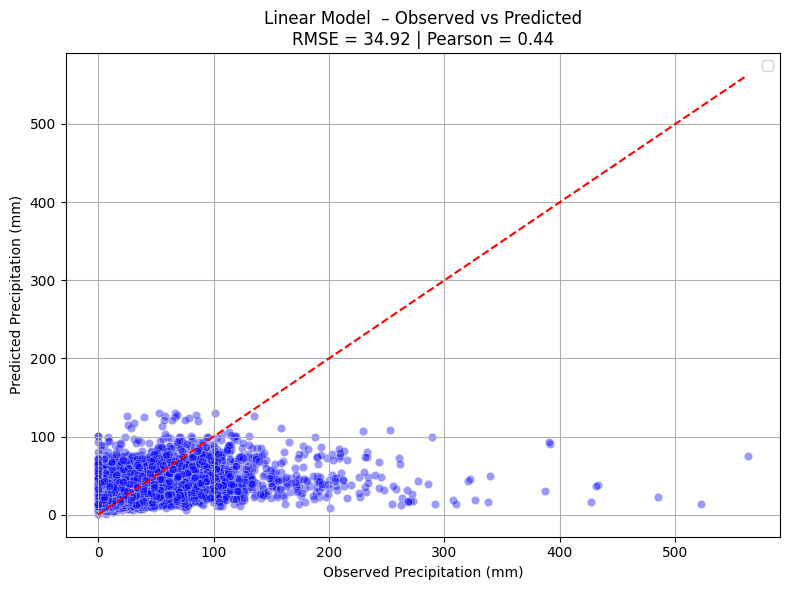

In [26]:
# Crear DataFrame para graficar
precip_resul_linear = pd.DataFrame({
    'precip': y_true,
    'precip_pred': y_pred
})

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(x='precip', y='precip_pred', data=precip_resul_linear, alpha=0.4, color="blue")
plt.plot([precip_resul_linear['precip'].min(), precip_resul_linear['precip'].max()],
         [precip_resul_linear['precip'].min(), precip_resul_linear['precip'].max()],
         'r--', label='')

plt.xlabel("Observed Precipitation (mm)")
plt.ylabel("Predicted Precipitation (mm)")
plt.title(f"Linear Model  – Observed vs Predicted\nRMSE = {rmse:.2f} | Pearson = {pearson_corr:.2f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Xgboost 

In [27]:
df.columns

Index(['Estacion', 'year', 'week', 'Precipitacion', 'Latitud', 'Longitud',
       'epi_week', 'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi',
       'cumbre', 'valle', 'rugosity', 'dem', 'ndvi', 'ndwi', 'mswep',
       'mswep_1km', 'week_sin', 'week_cos', 'mswep_dem', 'ndvi_rugosity',
       'tpi2'],
      dtype='object')

## Optimización bayesiana en paralelo

In [28]:
# optuna_downscaling_parallel.py
# Correr en un servidor

import optuna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import os


features = [
    "mswep_1km", "mswep", "tmax_saga", "tmin_saga", "slope", "aspect",
    "tpi", "cumbre", "valle", "rugosity", "dem", "ndvi", "ndwi",
    "week_sin", "week_cos", "Latitud", "Longitud",
    "mswep_dem", "ndvi_rugosity", "tpi2"
]
target = "Precipitacion"

print("✅ Cargando datos...")
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values
stations = df["Estacion"].values
weeks = df["epi_week"].values
uniq_weeks = np.sort(np.unique(weeks))

# ---------------------- 2. EVALUACION PARALALA POR FOLD ----------------------
def evaluate_fold(X, y, weeks, stations, blk, st, params):
    mask_w = np.isin(weeks, blk)
    mask_te_blk = mask_w & (stations == st)
    mask_tr_blk = ~mask_te_blk
    if mask_te_blk.sum() == 0 or mask_tr_blk.sum() == 0:
        return None

    model = XGBRegressor(**params)
    model.fit(X[mask_tr_blk], y[mask_tr_blk])
    y_tr_p = model.predict(X[mask_tr_blk])
    y_te_p = model.predict(X[mask_te_blk])
    y_tr_r = y[mask_tr_blk]
    y_te_r = y[mask_te_blk]

    rm_tr = np.sqrt(mean_squared_error(y_tr_r, y_tr_p))
    rm_te = np.sqrt(mean_squared_error(y_te_r, y_te_p))
    r_tr_val = pearsonr(y_tr_r, y_tr_p)[0] if len(np.unique(y_tr_r)) > 1 else np.nan
    r_te_val = pearsonr(y_te_r, y_te_p)[0] if len(np.unique(y_te_r)) > 1 else np.nan
    return rm_tr, rm_te, r_tr_val, r_te_val

def spatiotemporal_cv_rmse(params, X, y, weeks, stations, uniq_weeks):
    week_blocks = [uniq_weeks[i:i+26] for i in range(0, len(uniq_weeks), 26)]
    tasks = [(blk, st) for blk in week_blocks for st in np.unique(stations[np.isin(weeks, blk)])]

    results = Parallel(n_jobs=-1)(
        delayed(evaluate_fold)(X, y, weeks, stations, blk, st, params)
        for blk, st in tasks
    )
    results = [r for r in results if r is not None]
    if not results:
        return float('inf')

    rms_tr, rms_te, r_tr, r_te = zip(*results)
    mean_rmse_te = np.mean(rms_te)
    mean_rmse_tr = np.mean(rms_tr)
    mean_r_te = np.nanmean(r_te)
    mean_r_tr = np.nanmean(r_tr)

    print(f"\u2705 Train: RMSE={mean_rmse_tr:.2f}, r={mean_r_tr:.3f} | Test: RMSE={mean_rmse_te:.2f}, r={mean_r_te:.3f}")

    rmse_gap = abs(mean_rmse_te - mean_rmse_tr)
    loss = mean_rmse_te + 0.5*rmse_gap + 0.3*abs(mean_r_te - mean_r_tr) + 0.2*(1 - abs(mean_r_te))
    return loss

# ---------------------- 3. FUNCION OBJETIVO ----------------------
def objective(trial):
    params = {
        "objective": "reg:tweedie",
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.3, 2.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0),
        "random_state": 42,
        "n_jobs": 1
    }
    loss = spatiotemporal_cv_rmse(params, X, y, weeks, stations, uniq_weeks)
    print(f"\n🎯 Trial {trial.number} terminado con pérdida compuesta: {loss:.4f}\n")
    return loss

# ---------------------- 4. CALLBACK ----------------------
def logging_callback(study, trial):
    print(f"📌 Trial {trial.number} → score: {trial.value:.4f}")
    print(f"🏆 Mejor hasta ahora: Trial {study.best_trial.number} con {study.best_value:.4f}")

# ---------------------- 5. CONFIGURAR Y EJECUTAR ----------------------
storage_path = "sqlite:///C:/Users/DAgudelo/Desktop/Downscaling/resul_bayes_opt/optuna_downscaling.db"
study = optuna.create_study(direction="minimize", storage=storage_path, load_if_exists=True)
study.optimize(objective, n_trials=100, n_jobs=12, show_progress_bar=True, callbacks=[logging_callback])

# ---------------------- 6. RESULTADOS Y GUARDADO ----------------------
print("\n✅ Optimización finalizada")
print("📌 Mejores hiperparámetros:")
print(study.best_params)
print(f"🎯 Pérdida compuesta mínima: {study.best_value:.4f}")

results_path = "C:/Users/DAgudelo/Desktop/Downscaling/resul_bayes_opt/optuna_trials_results.csv"
study.trials_dataframe().to_csv(results_path, index=False)
print(f"📁 Resultados guardados en {results_path}")

[I 2025-10-13 14:03:15,433] A new study created in RDB with name: no-name-f86e302b-f470-4e81-b3a4-5a49411440fc


✅ Cargando datos...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Train: RMSE=25.80, r=0.759 | Test: RMSE=26.25, r=0.601

🎯 Trial 8 terminado con pérdida compuesta: 26.6093

✅ Train: RMSE=28.20, r=0.693 | Test: RMSE=26.71, r=0.576

🎯 Trial 1 terminado con pérdida compuesta: 27.5781

[I 2025-10-13 14:07:44,271] Trial 8 finished with value: 26.609319686352606 and parameters: {'tweedie_variance_power': 1.5462156021835605, 'learning_rate': 0.08396209336471093, 'n_estimators': 649, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.7342787134565906, 'subsample': 0.9424402057309755, 'colsample_bytree': 0.9089056243120948, 'reg_lambda': 1.0985737504112494}. Best is trial 8 with value: 26.609319686352606.
📌 Trial 8 → score: 26.6093
🏆 Mejor hasta ahora: Trial 8 con 26.6093
[I 2025-10-13 14:07:44,342] Trial 1 finished with value: 27.578115718713768 and parameters: {'tweedie_variance_power': 1.4125029752987621, 'learning_rate': 0.12189755865587318, 'n_estimators': 665, 'max_depth': 2, 'min_child_weight': 10, 'gamma': 0.7295478218382471, 'subsample': 0.68087691

## Mejor corrida Xgboost

In [29]:
study.best_params

{'tweedie_variance_power': 1.8732166885173056,
 'learning_rate': 0.04773030812738962,
 'n_estimators': 517,
 'max_depth': 5,
 'min_child_weight': 10,
 'gamma': 0.5894197677412255,
 'subsample': 0.9938287519910523,
 'colsample_bytree': 0.9048575198535257,
 'reg_lambda': 3.3520368774222637}

In [30]:

# --- función worker para una tarea (fold espaciotemporal) ---
def _worker_metrics(params, X, y, tr_idx, te_idx):
    # Modelo con 1 hilo para evitar nested parallelism
    model = XGBRegressor(
        n_jobs=1,                # clave para paralelizar fuera con joblib
        tree_method="hist",      # rápido en CPU
        random_state=0,
        **params
    )
    model.fit(X[tr_idx], y[tr_idx])

    y_tr_p = model.predict(X[tr_idx])
    y_te_p = model.predict(X[te_idx])

    y_tr_r = y[tr_idx]
    y_te_r = y[te_idx]

    rm_tr = float(np.sqrt(mean_squared_error(y_tr_r, y_tr_p)))
    rm_te = float(np.sqrt(mean_squared_error(y_te_r, y_te_p)))

    r_tr = pearsonr(y_tr_r, y_tr_p)[0] if np.unique(y_tr_r).size > 1 else np.nan
    r_te = pearsonr(y_te_r, y_te_p)[0] if np.unique(y_te_r).size > 1 else np.nan

    return rm_tr, rm_te, r_tr, r_te

# --- versión paralela de tu CV ---
def spatiotemporal_cv_rmse_parallel(params, X, y, weeks, stations, uniq_weeks, block_size=26, n_jobs=-1, verbose=5):
    # 1) Construir bloques de semanas
    week_blocks = [uniq_weeks[i:i+block_size] for i in range(0, len(uniq_weeks), block_size)]

    # 2) Preconstruir todas las tareas (índices train/test por bloque-estación)
    tasks = []
    for blk in week_blocks:
        mask_w = np.isin(weeks, blk)
        st_blocks = np.unique(stations[mask_w])

        for st in st_blocks:
            te_mask = mask_w & (stations == st)
            if not te_mask.any():
                continue
            tr_mask = ~te_mask
            if not tr_mask.any():
                continue
            te_idx = np.flatnonzero(te_mask)
            tr_idx = np.flatnonzero(tr_mask)
            tasks.append((tr_idx, te_idx))

    if len(tasks) == 0:
        raise ValueError("No se generaron tareas; revisa weeks/stations y el tamaño de bloque.")

    # 3) Ejecutar en paralelo
    results = Parallel(n_jobs=n_jobs, backend="loky", verbose=verbose)(
        delayed(_worker_metrics)(params, X, y, tr_idx, te_idx) for tr_idx, te_idx in tasks
    )

    # 4) Agregar métricas
    rms_tr, rms_te, r_tr, r_te = map(np.array, zip(*results))

    mean_rmse_tr = float(np.mean(rms_tr))
    mean_rmse_te = float(np.mean(rms_te))
    mean_r_tr    = float(np.nanmean(r_tr))
    mean_r_te    = float(np.nanmean(r_te))

    print(f"Train: RMSE={mean_rmse_tr:.2f}, r={mean_r_tr:.3f} | "
          f"Test: RMSE={mean_rmse_te:.2f}, r={mean_r_te:.3f}")

    return mean_rmse_te  # objetivo a minimizar

In [31]:
# features, target, df limpios como ya los tienes
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values
stations = df["Estacion"].values
weeks    = df["epi_week"].values
uniq_weeks = np.sort(np.unique(weeks))

best_params = {
    "objective":"reg:tweedie",
    'tweedie_variance_power': 1.8732166885173056,
    'learning_rate': 0.04773030812738962,
    'n_estimators': 517,
    'max_depth': 5,
    'min_child_weight': 10,
    'gamma': 0.5894197677412255,
    'subsample': 0.9938287519910523,
    'colsample_bytree': 0.9048575198535257,
    'reg_lambda': 3.3520368774222637}
        
features = [
    "mswep_1km","mswep","tmax_saga","tmin_saga","slope","aspect",
    "tpi","cumbre","valle","rugosity","dem","ndvi","ndwi",
    "week_sin","week_cos","Latitud","Longitud",
    # tus interacciones
    "mswep_dem","ndvi_rugosity","tpi2"
]
target = "Precipitacion"

spatiotemporal_cv_rmse_parallel(best_params, X, y, weeks, stations, uniq_weeks,
                                block_size=26, n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 521 out of 526 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 526 out of 526 | elapsed:   18.1s finished


Train: RMSE=25.71, r=0.770 | Test: RMSE=25.94, r=0.603


25.944263714282634

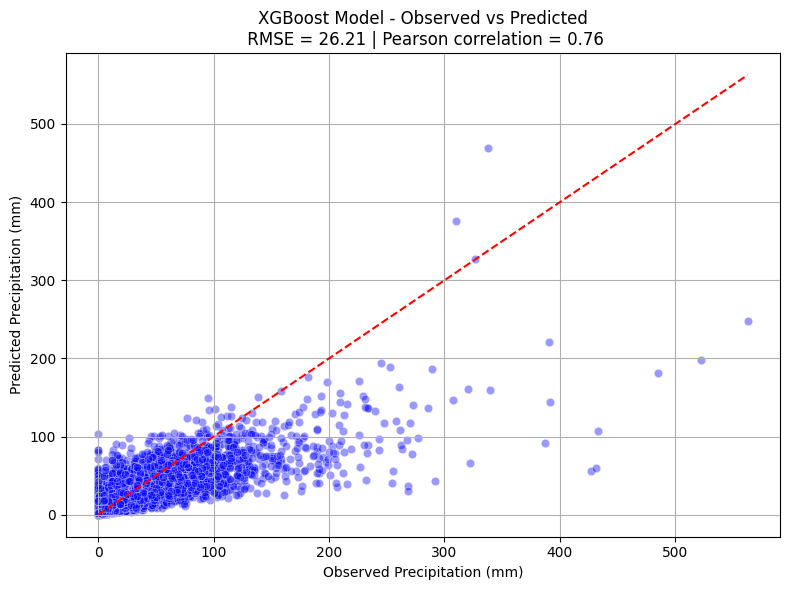

=== Comparación de modelos en Test ===
XGBoost Mejorado: RMSE = 26.21 mm, Pearson r = 0.76


In [49]:

features = sorted([
    "mswep_1km", "tmax_saga", "tmin_saga",
     "ndvi", "ndwi",
    "week_sin", "Latitud", 
    "mswep_dem"
])
target = "Precipitacion"
df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]
final_model = XGBRegressor(**best_params)
final_model.fit(X, y)
y_pred_xgb = final_model.predict(X)
df['precip_xgboost'] = final_model.predict(X)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
rmse = np.sqrt(mean_squared_error(y, y_pred_xgb))
pearson_corr = pearsonr(y, y_pred_xgb)[0]
precip_resul = pd.DataFrame({
    'precip': y,
    'precip_pred': y_pred_xgb
})
plt.figure(figsize=(8,6))
sns.scatterplot(x='precip', y='precip_pred', data=precip_resul, alpha=0.4,color="blue")
plt.plot([precip_resul['precip'].min(), precip_resul['precip'].max()], [precip_resul['precip'].min(), precip_resul['precip'].max()], 'r--')
plt.xlabel("Observed Precipitation (mm)")
plt.ylabel("Predicted Precipitation (mm)")
plt.title(f"XGBoost Model - Observed vs Predicted\n RMSE = {rmse:.2f} | Pearson correlation = {pearson_corr:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()
def metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r, _  = pearsonr(y_true, y_pred)
    print(f"{name}: RMSE = {rmse:.2f} mm, Pearson r = {r:.2f}")
print("=== Comparación de modelos en Test ===")
metrics("XGBoost Mejorado"  , y, y_pred_xgb)

## Shapply Values Xgboost

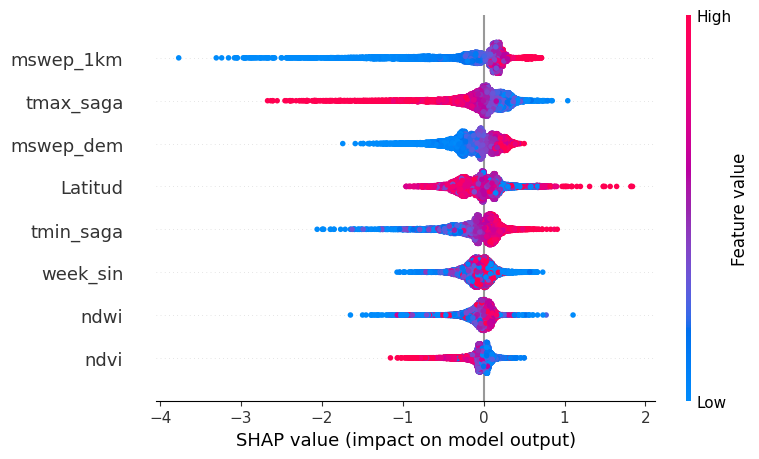

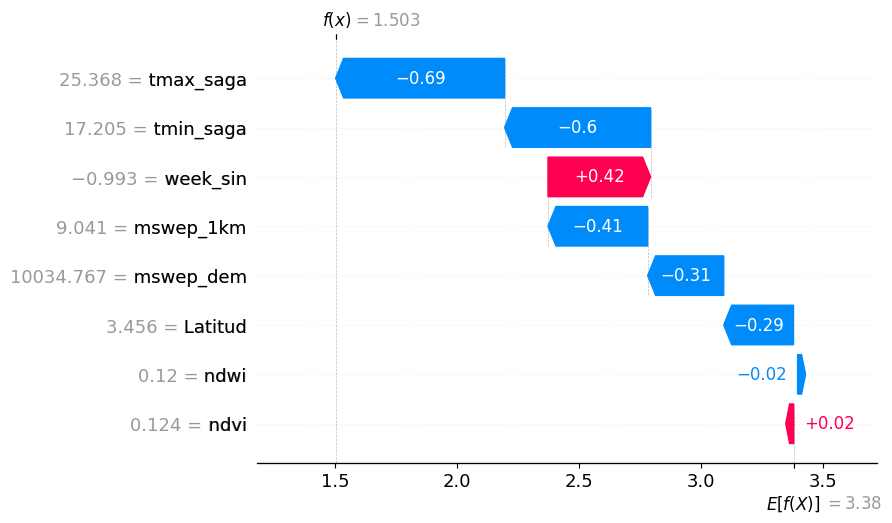

In [50]:
# Supón que ya tienes tu modelo entrenado
# model = xgb.XGBRegressor(...)
# model.fit(X_train, y_train)

# Usar un subconjunto si hay muchos datos
X_sample = X  # opcional, para visualización más rápida

# Crear el objeto SHAP explainer
explainer = shap.Explainer(final_model)

# Calcular los valores SHAP
shap_values = explainer(X_sample)

# Visualización: resumen de importancia global
shap.summary_plot(shap_values, X_sample)

# Visualización: aportes en una predicción individual
shap.plots.waterfall(shap_values[0])

## Resultados mejor modelo Xgboost

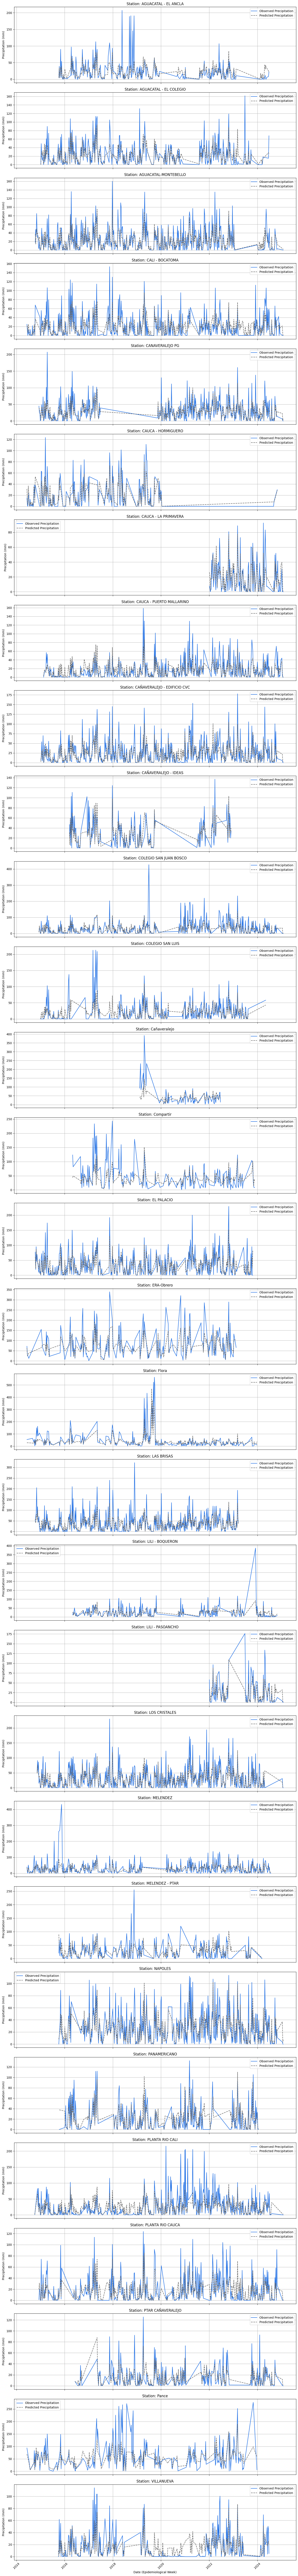

In [51]:
# Usar todos los datos disponibles para todas las estaciones (sin limitar a 50 por estación)
full_plot_data = df.copy()
full_plot_data['Fecha'] = pd.to_datetime(full_plot_data['epi_week'] + '-1', format='%Y-%W-%w', errors='coerce')
full_plot_data = full_plot_data.dropna(subset=['Precipitacion', 'Precipitacion', 'Fecha'])

# Obtener estaciones únicas
stations = full_plot_data['Estacion'].unique()

# Crear un gráfico por estación
fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(14, 4 * len(stations)), sharex=True)

# Asegurar que axes es iterable
if len(stations) == 1:
    axes = [axes]

# Generar los subgráficos
for ax, station in zip(axes, stations):
    data = full_plot_data[full_plot_data['Estacion'] == station]
    ax.plot(data['Fecha'], data['Precipitacion'], label='Observed Precipitation', linestyle='-',color="#2673E5")
    ax.plot(data['Fecha'], data['precip_xgboost'], label='Predicted Precipitation', linestyle='--',color="#696969")
    ax.set_title(f'Station: {station}')
    ax.set_ylabel('Precipitation (mm)')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.xlabel("Date (Epidemiological Week)")
plt.tight_layout()
plt.show()

In [52]:
assesment = df[["Estacion","year","week","Precipitacion","mswep_1km","precip_xgboost"]]

# Calcular métricas
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    var_ratio = np.var(y_pred) / np.var(y_true)
    return rmse, corr, bias, var_ratio


grouped_results = []

for station, group in assesment.groupby("Estacion"):
    metrics_saga = compute_metrics(group["Precipitacion"], group["mswep_1km"])
    metrics_xgb = compute_metrics(group["Precipitacion"], group["precip_xgboost"])
    improvement = [s - x for s, x in zip(metrics_saga, metrics_xgb)]
    
    for metric, saga_val, xgb_val, imp_val in zip(["RMSE", "Pearson r", "Bias (mean error)", "Variance Ratio"], metrics_saga, metrics_xgb, improvement):
        grouped_results.append({
            "Station": station,
            "Metric": metric,
            "MSWEP_1km": saga_val,
            "XGBoost": xgb_val,
            "Improvement": imp_val
        })

results_by_station_df = pd.DataFrame(grouped_results)

results_by_station_df

Station             Metric  MSWEP_1km    XGBoost  \
0      AGUACATAL - EL ANCLA               RMSE  35.614430  25.776553   
1      AGUACATAL - EL ANCLA          Pearson r   0.385122   0.598663   
2      AGUACATAL - EL ANCLA  Bias (mean error)  10.185470  -1.713548   
3      AGUACATAL - EL ANCLA     Variance Ratio   0.854603   0.263132   
4    AGUACATAL - EL COLEGIO               RMSE  28.016128  18.622732   
..                      ...                ...        ...        ...   
115                   Pance     Variance Ratio   0.270162   0.221437   
116              VILLANUEVA               RMSE  30.829133  16.118102   
117              VILLANUEVA          Pearson r   0.529257   0.723924   
118              VILLANUEVA  Bias (mean error)  17.595698   0.322233   
119              VILLANUEVA     Variance Ratio   1.500911   0.377350   

     Improvement  
0       9.837877  
1      -0.213541  
2      11.899018  
3       0.591470  
4       9.393396  
..           ...  
115     0.048725  
116    14.711031  
117    -0.194667  
118    17.273465  
119     1.123561  

[120 rows x 5 columns]

In [53]:
## Guarda el  mejor modelo para tmax

dump(final_model, r"C:\Users\DAgudelo\Desktop\Downscaling\models\xgb_precip.joblib")

['C:\\Users\\DAgudelo\\Desktop\\Downscaling\\models\\xgb_precip.joblib']